In [1]:
import os, json, wandb, torch
import numpy as np
import torch.nn.functional as F
from monai import transforms, data
from monai.data import DataLoader, DistributedSampler
from monai.utils import set_determinism
from tqdm import tqdm
import torch.distributed as dist
import torch
from torch import nn
from diffusers import AutoencoderKLWan, WanTransformer3DModel
from peft import LoraConfig, inject_adapter_in_model
from flow_match import FlowMatchScheduler

[2025-05-06 06:02:54,941] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/pytorch/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/pytorch/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/opt/conda/envs/pytorch/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/opt/conda/envs/pytorch/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/opt/conda/envs/pytorch/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/opt/conda/envs/pytorch/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/opt/conda/envs/pytorch/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefi

In [2]:
state_dict = torch.load("/working/Project/StableDiffusion/Stable_diffusion/deepspeed_checkpoint/SD_latest/SD/pytorch_model.bin")

In [3]:
def add_lora_to_model(model, lora_rank=4, lora_alpha=4, lora_target_modules="q,k,v,o,ffn.0,ffn.2", init_lora_weights="kaiming", pretrained_lora_path=None, state_dict_converter=None):
    # Add LoRA to UNet
    
    lora_alpha = lora_alpha
    if init_lora_weights == "kaiming":
        init_lora_weights = True
        
    lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_alpha,
        init_lora_weights=init_lora_weights,
        target_modules=lora_target_modules.split(","),
    )
    model = inject_adapter_in_model(lora_config, model)
    for param in model.parameters():
        # Upcast LoRA parameters into fp32
        if param.requires_grad:
            param.data = param.to(torch.float32)
    for param in model.patch_embedding.parameters():
        param.requires_grad = True

    for param in model.proj_out.parameters():
        param.requires_grad = True
    return model

In [4]:
transformer = WanTransformer3DModel.from_pretrained("Wan-AI/Wan2.1-T2V-1.3B-Diffusers", subfolder="transformer", torch_dtype=torch.bfloat16, cache_dir="/working/cache/huggingface/hub")
old_patch_embed = transformer.patch_embedding
new_patch_embed = nn.Conv3d(
    in_channels=old_patch_embed.in_channels*8,               # 修改为新输入通道
    out_channels=old_patch_embed.out_channels,
    kernel_size=old_patch_embed.kernel_size,
    stride=old_patch_embed.stride,
    padding=old_patch_embed.padding
)
transformer.patch_embedding = new_patch_embed
old_proj_out = transformer.proj_out
new_proj_out = nn.Linear(
    in_features=old_proj_out.in_features,
    out_features=old_proj_out.out_features*4,            # 修改为新输出通道
    bias=True
)
transformer.proj_out = new_proj_out
transformer = add_lora_to_model(transformer, lora_rank=4, lora_alpha=4, lora_target_modules="to_q,to_k,to_v,to_out.0,linear_1,linear_2", init_lora_weights="kaiming", pretrained_lora_path=None, state_dict_converter=None)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dit_state_dict = {}
for k,v in state_dict.items():
    if 'vae' not in k:
        dit_state_dict[k.replace("model.", "")] = v
vae_state_dict = {}
for k,v in state_dict.items():
    if 'vae' in k:
        vae_state_dict[k.replace("vae.", "")] = v

In [6]:
transformer.load_state_dict(dit_state_dict, strict=True)

<All keys matched successfully>

In [2]:
vae = AutoencoderKLWan.from_pretrained("Wan-AI/Wan2.1-T2V-1.3B-Diffusers", subfolder="vae", torch_dtype=torch.bfloat16, cache_dir="/working/cache/huggingface/hub")

In [13]:
print(vae.config['latents_mean'])
print(vae.config['latents_std'])
latents_mean = torch.tensor([vae.config['latents_mean']], dtype=torch.float32).view(1, 16, 1, 1, 1)
latents_std = torch.tensor([vae.config['latents_std']], dtype=torch.float32).view(1, 16, 1, 1, 1)

[-0.7571, -0.7089, -0.9113, 0.1075, -0.1745, 0.9653, -0.1517, 1.5508, 0.4134, -0.0715, 0.5517, -0.3632, -0.1922, -0.9497, 0.2503, -0.2921]
[2.8184, 1.4541, 2.3275, 2.6558, 1.2196, 1.7708, 2.6052, 2.0743, 3.2687, 2.1526, 2.8652, 1.5579, 1.6382, 1.1253, 2.8251, 1.916]


In [ ]:
latents_mean = torch.tensor([vae.config['latents_mean']], dtype=torch.float32).view(1, 16, 1, 1, 1)
latents_std = torch.tensor([vae.config['latents_std']], dtype=torch.float32).view(1, 16, 1, 1, 1)

fake_latents = torch.randn(1, 16, 32, 24, 24)
fake_latents = (fake_latents - latents_mean) / latents_std

restored_latents = fake_latents * latents_std + latents_mean

print(fake_latents.mean())
print(fake_latents.std())

tensor(0.0476)
tensor(0.8550)


In [8]:
vae.load_state_dict(vae_state_dict, strict=True)

<All keys matched successfully>

In [9]:
train_json_path = './json/train.json'
with open(train_json_path) as f:
    train_files = json.load(f)
val_json_path = './json/val.json'
with open(val_json_path) as f:
    val_files = json.load(f)
train_batchsize  = 2

train_transforms = transforms.Compose(
    [
        transforms.CopyItemsd(keys=["image"], names=["path"]),
        transforms.LoadImaged(keys=["image","brainmask"]),
        transforms.EnsureChannelFirstd(keys=["image","brainmask"]),
        transforms.EnsureTyped(keys=["image","brainmask"]),
        transforms.Orientationd(keys=["image","brainmask"], axcodes="RAS"),
        transforms.RandAffined(
            keys=["image","brainmask"],
            rotate_range=(-np.pi / 36, np.pi / 36),
            translate_range=(-1, 1),
            scale_range=(-0.05, 0.05),
            padding_mode="zeros",
            prob=0.5,
        ),
        transforms.CropForegroundd(
            keys=["image", "brainmask"],
            source_key="brainmask",
            allow_smaller=False,
        ),
        transforms.ResizeWithPadOrCropd(keys=["image","brainmask"], spatial_size=(192, 192, 141)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0.5, upper=99.5, b_min=0, b_max=1,clip=True ),
    ]
)
train_ds = data.Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=train_batchsize, shuffle=False, num_workers=1, persistent_workers=True, drop_last=True, sampler=None)

val_transforms = transforms.Compose(
    [
        transforms.CopyItemsd(keys=["image"], names=["path"]),
        transforms.LoadImaged(keys=["image","brainmask"]),
        transforms.EnsureChannelFirstd(keys=["image","brainmask"]),
        transforms.EnsureTyped(keys=["image","brainmask"]),
        transforms.Orientationd(keys=["image","brainmask"], axcodes="RAS"),
        transforms.CropForegroundd(
            keys=["image", "brainmask"],
            source_key="brainmask",
            allow_smaller=False,
        ),
        transforms.ResizeWithPadOrCropd(keys=["image","brainmask"], spatial_size=(192, 192, 141)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0.5, upper=99.5, b_min=0, b_max=1),
    ]
)
val_ds = data.Dataset(data=val_files, transform=train_transforms)
val_loader = DataLoader(val_ds, batch_size=train_batchsize, shuffle=False, num_workers=1, persistent_workers=True, drop_last=True, sampler=None)

In [10]:
from flow_match import FlowMatchScheduler
scheduler = FlowMatchScheduler(shift=5, sigma_min=0.0, extra_one_step=True)
scheduler.set_timesteps(50, denoising_strength=1.0, shift=5.0)

In [11]:
device = torch.device("cuda:0")
transformer.to(device)
vae.to(device)
transformer.eval()
vae.eval()

AutoencoderKLWan(
  (encoder): WanEncoder3d(
    (nonlinearity): SiLU()
    (conv_in): WanCausalConv3d(3, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (down_blocks): ModuleList(
      (0-1): 2 x WanResidualBlock(
        (nonlinearity): SiLU()
        (norm1): WanRMS_norm()
        (conv1): WanCausalConv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (norm2): WanRMS_norm()
        (dropout): Dropout(p=0.0, inplace=False)
        (conv2): WanCausalConv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (conv_shortcut): Identity()
      )
      (2): WanResample(
        (resample): Sequential(
          (0): ZeroPad2d((0, 1, 0, 1))
          (1): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (3): WanResidualBlock(
        (nonlinearity): SiLU()
        (norm1): WanRMS_norm()
        (conv1): WanCausalConv3d(96, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (norm2): WanRMS_norm()
        (dropout): Dropout(p=0.0, inplace=False)
 

In [48]:
mask = torch.tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.]])
print(mask)
mask = mask.unsqueeze(2)
mask = mask.repeat(1,1,16)
mask = mask.view(2,16*4,1,1,1)
mask = mask.to(torch.bfloat16).to(device)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.]])


In [17]:
for batch in val_loader:
    image = batch['image']
    # mask = batch['brainmask']
    path = batch['path']
    image = image.permute(0, 1, 4, 2, 3)  # [B, C, H, W, D] -> [B, D, H, W, C]
    B, C, D, H, W  = image.shape
    image = image.view(B*C, D, H, W)  # [4, 1, D, H, W]
    image = image.unsqueeze(1)
    image = image.repeat(1, 3, 1, 1, 1)  # [4, 3, D, H, W]
    image = image.to(torch.bfloat16).to(device)
    with torch.no_grad():
        latent = vae.encode(image, return_dict=True)
        latent = latent.latent_dist.sample()
        vae = vae.to('cpu')
        latents_cond = latent.view(B, 64, -1, int(H/8), int(W/8))
        z_c = latents_cond
        z_c_keep = z_c
        z_c_zero = torch.zeros_like(z_c, device=device, dtype=torch.bfloat16)
        z_c_in = z_c_keep * (1-mask) + z_c_zero * mask
        z_c_in = z_c_in.to(dtype=torch.bfloat16)

        noise = torch.randn_like(latents_cond)
        noise = noise.to(torch.bfloat16).to(device)
        latents = noise
        encoder_hidden_states = torch.zeros([1,256,4096], device=device, dtype=torch.bfloat16)
        for progress_id, timestep in enumerate(tqdm(scheduler.timesteps)):
            inp = torch.cat([latents, z_c_in], dim=1)
            timestep = timestep.unsqueeze(0).to(dtype=torch.bfloat16, device=device)
            with torch.autocast("cuda"):
                noise_pred = transformer(inp, timestep, encoder_hidden_states).sample
            latents = scheduler.step(noise_pred, scheduler.timesteps[progress_id], latents)
    break

100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


In [ ]:
vae = vae.to(device)

In [20]:
latents.shape

torch.Size([2, 64, 36, 24, 24])

In [21]:
latents_out = latents.view(-1, 16, 36, 24, 24)
print(latents_out.shape)

torch.Size([8, 16, 36, 24, 24])


In [40]:
z_c_in.shape

torch.Size([2, 64, 36, 24, 24])

In [41]:
latents_out = z_c_in.view(-1, 16, 36, 24, 24)
print(latents_out.shape)

torch.Size([8, 16, 36, 24, 24])


In [42]:
with torch.no_grad():
    with torch.autocast("cuda"):
        decoded = vae.decode(latents_out, return_dict=True)

In [43]:
output = decoded.sample.cpu().numpy()
print(output.shape)

(8, 3, 141, 192, 192)


In [26]:
import matplotlib.pyplot as plt

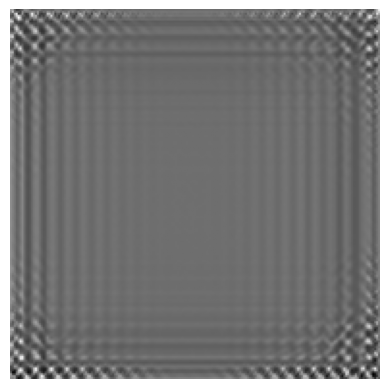

In [47]:
plt.imshow(output[0, 2, 70, :, :], cmap='gray')
plt.axis('off')
plt.show()

In [22]:
from glob import glob
temp = glob('/data/users/neob/BraSyn2025/*')
print(len(temp))

0
